# Image Stitching

1. Leitura das imagens 
2. Features Match com ORB
3. Features Matching 
4. Homografia

In [1]:
#Bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#Imagens
img1 = cv2.imread(os.path.join(os.getcwd(),'foto1.jpeg'))
img2 = cv2.imread(os.path.join(os.getcwd(),'foto2.jpeg'))

img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)



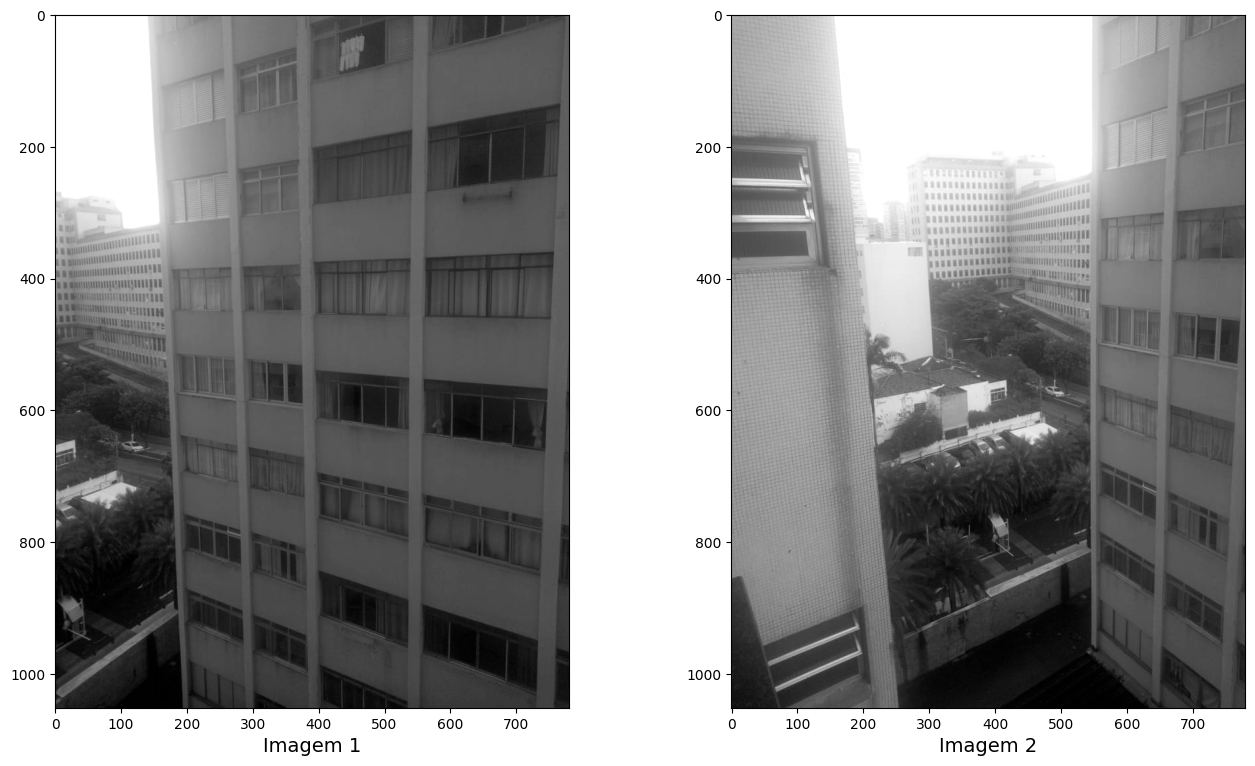

In [2]:
#Plot das imagens em tons de cinza
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
ax1.imshow(img1_gray, cmap="gray")
ax1.set_xlabel("Imagem 1", fontsize=14)
ax2.imshow(img2_gray, cmap="gray")
ax2.set_xlabel("Imagem 2", fontsize=14)
plt.show()

# ORB

*   Boa alternativa para o SIFT e o SURF em relação ao custo computacional e performaces de macths. 
*   O ORB é basicamente a fusão entre a detecção de keypoints do FAST e as descrições feitas pelo BRIEF. Primeiramente o FAST encontra os keypoints e então encontra os melhores N pontos. Despois BRIEF avalia as respectivas correspondências encontras pelos pontos.
*    O uso mais comum do ORB é passar o nFeatures, responsável pelo máx. números das features (default = 500) e o WTA_K que encontra a orientação das features encontras (default = NORM_HAMMING)


*  Parâmetros:

1.  **nfeatures** O número máximo de recursos a serem retidos.

2.  **scaleFactor** Taxa de decimação da pirâmide, maior que 1. scaleFactor == 2 significa a pirâmide clássica, onde cada próximo nível tem 4x menos pixels do que o anterior, mas esse fator de grande escala degradará drasticamente as pontuações correspondentes. Por outro lado, muito próximo a 1 fator de escala significará que, para cobrir determinada faixa de escala, você precisará de mais níveis de pirâmide e, portanto, a velocidade de detecção sofrerá.

3.  **nlevels** O número de níveis da pirâmide.

4.  **edgeThreshold** Esse é o tamanho da borda em que os recursos não são detectados. Deve corresponder aproximadamente ao parâmetro patchSize.

5.  **firstLevel** O nível da pirâmide na qual colocar a imagem de origem. As camadas anteriores são preenchidas com a imagem de origem aumentada.

6.  **WTA_K** O número de pontos que produzem cada elemento do descritor BRIEF orientado. O valor padrão 2 significa o BRIEF em que pegar um par de pontos aleatórios e comparar seus brilhos, para obter uma resposta 0/1. Outros valores possíveis são 3 e 4. Por exemplo, 3 significa que pegamos 3 pontos aleatórios (é claro, essas coordenadas de pontos são aleatórias, mas são geradas a partir da semente predefinida, de modo que cada elemento do descritor BRIEF é calculado deterministicamente a partir de o retângulo de pixels), encontre o ponto de brilho máximo e o índice de saída do vencedor (0, 1 ou 2). Essa saída ocupará 2 bits e, portanto, precisará de uma variante especial da distância de Hamming, indicada como NORM_HAMMING2 (2 bits por compartimento). Quando WTA_K = 4, tomamos 4 pontos aleatórios para calcular cada compartimento (que também ocupará 2 bits com valores possíveis 0, 1, 2 ou 3).

7.  **scoreType** O HARRIS_SCORE padrão significa que o algoritmo Harris é usado para classificar os recursos (a pontuação é gravada em KeyPoint::score e é usada para manter os melhores recursos de nfeatures); FAST_SCORE é um valor alternativo do parâmetro que produz pontos-chave um pouco menos estáveis, mas é um pouco mais rápido de calcular.

8.  **patchSize** Tamanho usado pelo descritor BRIEF orientado.

9.  **fastThreshold** encontrar o Threshold de maneira rápida.



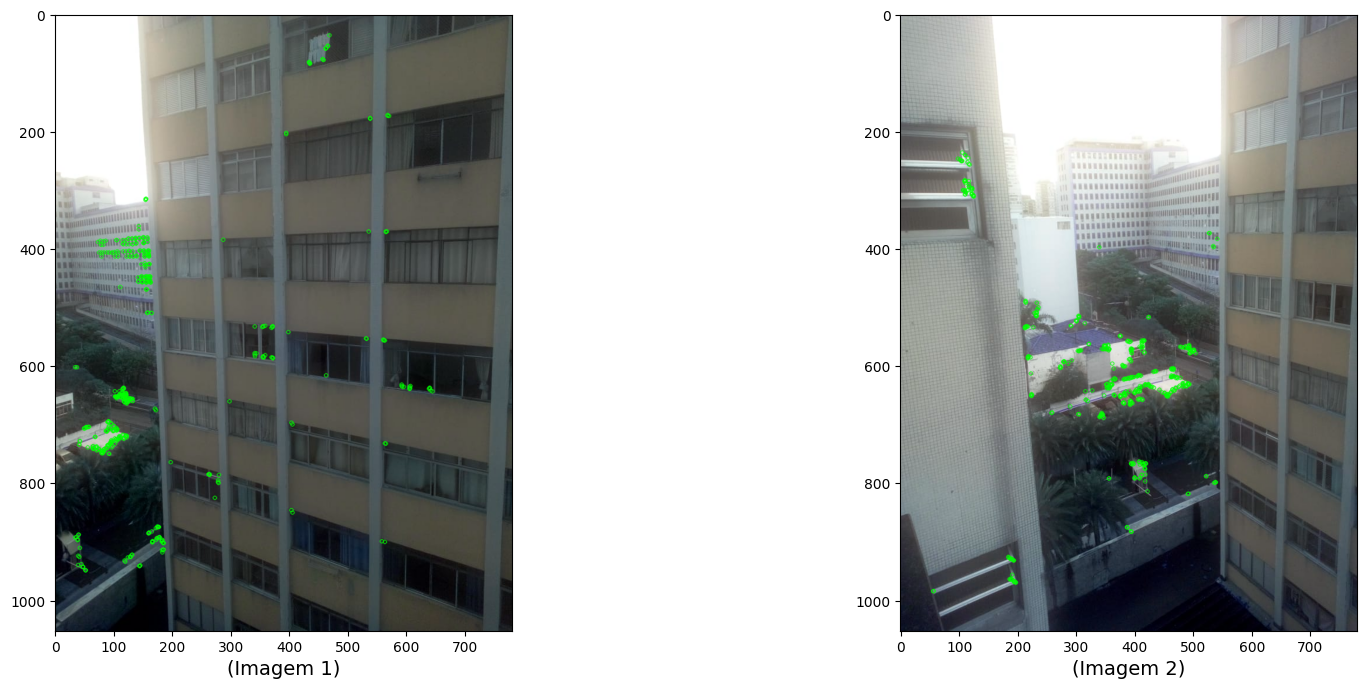

In [3]:
#Features Match com ORB
detect = cv2.ORB_create()

#kp = Keypoints, feat = descritores
kp1, feat1 = detect.detectAndCompute(img1_gray, None)
kp2, feat2 = detect.detectAndCompute(img2_gray, None)

#Plot com os decritores
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax1.imshow(cv2.drawKeypoints(img1,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(Imagem 1)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(img2,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(Imagem 2)", fontsize=14)
plt.show()

# BFMatcher

O brute-Force matcher é simples. Ele pega o descritor de um recurso/feature da primeira imagem e combina com todos os outros recursos/features da segunda imagem usando algum cálculo de distância. E o mais próximo é retornado.

Para o BF matcher, são necessários dois parâmetros opcionais. O primeiro é o **normType**. Especifica a medição da distância a ser usada. Por padrão, é **cv2.NORM_L2**. É bom para SIFT, SURF etc (cv2.NORM_L1 também está lá). Para descritores baseados em cadeias binárias como ORB, BRIEF, BRISK etc, **cv2.NORM_HAMMING** deve ser usado, que usou a distância de Hamming como medida. Se o ORB estiver usando WTA_K == 3 ou 4, cv2.NORM_HAMMING2 deve ser usado.

O segundo parâmetro é a variável booleana, **crossCheck**, que é falsa por padrão. Se for verdade, o Matcher retornará apenas as correspondências com o valor (i, j), de modo que o i-ésimo descritor no conjunto A tenha o j-ésimo descritor no conjunto B como a melhor correspondência e vice-versa. Ou seja, os dois recursos nos dois conjuntos devem coincidir. Ele fornece resultados consistentes e é uma boa alternativa ao teste de proporção proposto por D.Lowe no papel SIFT.

Raw matches:  150


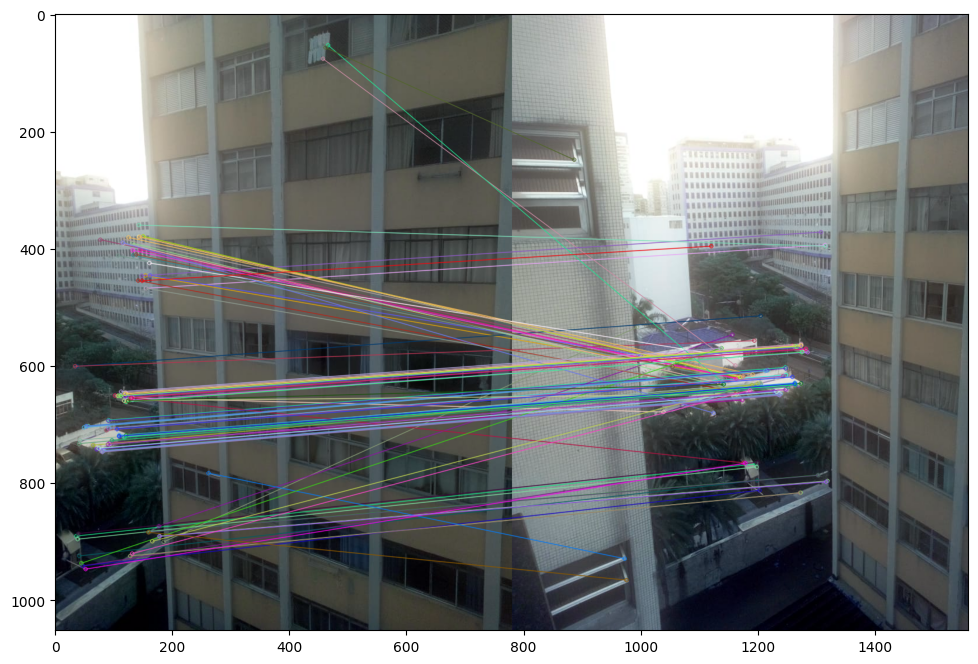

In [4]:
#Achar as correspondecias entre as imagens (BFMatcher)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
best_matches = bf.match(feat1, feat2)
raw_matches = sorted(best_matches, key=lambda x: x.distance)
print("Raw matches: ", len(raw_matches))

fig = plt.figure(figsize=(20,8))
img3 = cv2.drawMatches(img1,kp1,img2,kp2,best_matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

# findHomography

Encontrar a pespectiva entre dois planos.

Parâmetros:

**srcpoints** - Coordenadas dos pontos da imagem original.
**dstPoints** - Coordenadas dos pontos da imagem alvo.
**method** - Método usada para computar a homografia da imagem. É possível passar três métodos: 
1.    0 - Um métodos regular usado em todos os pontos.
2.    RANSAC - Métodos robusto baseado em RANSAC
3.    LMEDS -  Menor mediana

**ransacReprojThreshold** - Erro máximo permitido de reprojeção para tratar um par de pontos em inliers (método usado apenas quando é setado o RANSAC). Ou seja, se:

||dstPoints - convertPointsHomogeneous(H*srcPoints)|| > ransacReprojThreshold

então o ponto em questão é considerado um desvio. Se srcPoints e dstPoints forem medidos em pixels, geralmente faz sentido definir esse parâmetro em algum lugar no intervalo de 1 a 10.


Ambos os métodos, RANSAC e LMeDS, etstam muitos subconjuntos aleatórios diferentes dos pares de pontos correspondentes (de quatro pares cada), estimam a matriz de homografia usando esse subconjunto e um algoritmo simples de mínimos quadrados e depois calculam a qualidade/qualidade da homografia computada (que é o número de inliers para o RANSAC ou o erro médio de re-projeção para os LMeDs). O melhor subconjunto é então usado para produzir a estimativa inicial da matriz de homografia e a máscara de inliers / outliers.

Independentemente do método, robusto ou não, a matriz de homografia computada é refinada ainda mais (usando inliers apenas no caso de um método robusto) com o método Levenberg-Marquardt para reduzir ainda mais o erro de re-projeção.

O método RANSAC pode lidar com praticamente qualquer proporção de outliers, mas precisa de um limite para distinguir inliers de outliers. O método LMeDS não precisa de nenhum limite, mas funciona corretamente apenas quando há mais de 50% de inliers. Por fim, se não houver discrepâncias e o ruído for bastante pequeno, use o método padrão (método = 0)




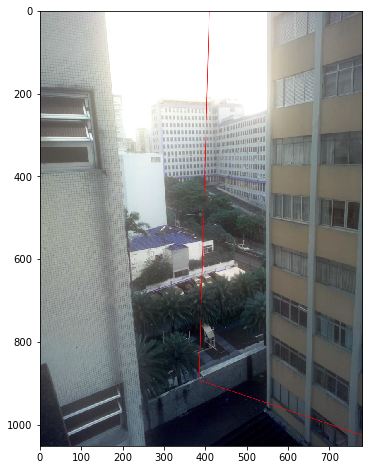

In [5]:
#A função drawMatches retorna os queryIdx e os trainIdx. Referentes aos keypoints da primeira e da segunda imagem

src_pts = np.float32([kp1[m.queryIdx].pt for m in raw_matches]).reshape(-1, 1, 2) #vetor coluna
dst_pts = np.float32([kp2[m.trainIdx].pt for m in raw_matches]).reshape(-1, 1, 2) #vetor coluna

H, mask  = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

h,w = img1_gray.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,H) # APenas calucular as coord dos box corners nas imagens.

img_final = cv2.polylines(img2,[np.int32(dst)],True,255,1, cv2.LINE_AA)
fig = plt.figure(figsize=(20,8))
plt.imshow(img_final)
plt.show()